In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import kornia.augmentation as K
from kornia.geometry.transform import Resize
from kornia.constants import Resample
from PIL import Image
import torchvision.transforms.functional as TF

In [2]:
import os
import sys

# Add root path to sys.path so imports work
sys.path.append(os.path.abspath(os.path.join('..')))


In [3]:
train_data_path = os.path.join("..","skin-disease-datasaet","train_set")
test_data_path = os.path.join("..","skin-disease-datasaet","test_set")

In [4]:
train_list_dir = os.listdir(train_data_path)
test_list_dir = os.listdir(test_data_path)

In [5]:
test_list_dir

['BA- cellulitis',
 'BA-impetigo',
 'FU-athlete-foot',
 'FU-nail-fungus',
 'FU-ringworm',
 'PA-cutaneous-larva-migrans',
 'VI-chickenpox',
 'VI-shingles']

In [6]:
data_train = []

for disease_name in train_list_dir:
    disease_folder_path = os.path.join(train_data_path, disease_name)
    train_disease_pic_names = os.listdir(disease_folder_path)

    for pic_name in train_disease_pic_names:
        pic_path = os.path.join(disease_folder_path, pic_name)
        data_train.append({"image_path": pic_path, "label": disease_name})
        
df_train = pd.DataFrame(data_train)

In [7]:
df_train

,image_path,label
0,..\skin-disease-datasaet\train_set\BA- celluli...,BA- cellulitis
1,..\skin-disease-datasaet\train_set\BA- celluli...,BA- cellulitis
2,..\skin-disease-datasaet\train_set\BA- celluli...,BA- cellulitis
3,..\skin-disease-datasaet\train_set\BA- celluli...,BA- cellulitis
4,..\skin-disease-datasaet\train_set\BA- celluli...,BA- cellulitis
...,...,...
920,..\skin-disease-datasaet\train_set\VI-shingles...,VI-shingles
921,..\skin-disease-datasaet\train_set\VI-shingles...,VI-shingles
922,..\skin-disease-datasaet\train_set\VI-shingles...,VI-shingles
923,..\skin-disease-datasaet\train_set\VI-shingles...,VI-shingles


In [8]:
data_test = []

for disease_name in test_list_dir:
    disease_folder_path = os.path.join(test_data_path, disease_name)
    test_disease_pic_names = os.listdir(disease_folder_path)

    for pic_name in test_disease_pic_names:
        pic_path = os.path.join(disease_folder_path, pic_name)
        data_test.append({"image_path": pic_path, "label": disease_name})
        
df_test = pd.DataFrame(data_test)

In [9]:
df_test

,image_path,label
0,..\skin-disease-datasaet\test_set\BA- cellulit...,BA- cellulitis
1,..\skin-disease-datasaet\test_set\BA- cellulit...,BA- cellulitis
2,..\skin-disease-datasaet\test_set\BA- cellulit...,BA- cellulitis
3,..\skin-disease-datasaet\test_set\BA- cellulit...,BA- cellulitis
4,..\skin-disease-datasaet\test_set\BA- cellulit...,BA- cellulitis
...,...,...
229,..\skin-disease-datasaet\test_set\VI-shingles\...,VI-shingles
230,..\skin-disease-datasaet\test_set\VI-shingles\...,VI-shingles
231,..\skin-disease-datasaet\test_set\VI-shingles\...,VI-shingles
232,..\skin-disease-datasaet\test_set\VI-shingles\...,VI-shingles


In [10]:
label_map = {
    "BA- cellulitis" : 0,
    'BA-impetigo':1,
 'FU-athlete-foot':2,
 'FU-nail-fungus':3,
 'FU-ringworm':4,
 'PA-cutaneous-larva-migrans':5,
 'VI-chickenpox':6,
 'VI-shingles':7
    
}

In [11]:
df_train["num_label"] = df_train["label"].map(label_map)

In [12]:
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)


In [13]:
df_train

,image_path,label,num_label
0,..\skin-disease-datasaet\train_set\FU-athlete-...,FU-athlete-foot,2
1,..\skin-disease-datasaet\train_set\VI-shingles...,VI-shingles,7
2,..\skin-disease-datasaet\train_set\BA- celluli...,BA- cellulitis,0
3,..\skin-disease-datasaet\train_set\VI-shingles...,VI-shingles,7
4,..\skin-disease-datasaet\train_set\FU-athlete-...,FU-athlete-foot,2
...,...,...,...
920,..\skin-disease-datasaet\train_set\BA- celluli...,BA- cellulitis,0
921,..\skin-disease-datasaet\train_set\FU-athlete-...,FU-athlete-foot,2
922,..\skin-disease-datasaet\train_set\VI-shingles...,VI-shingles,7
923,..\skin-disease-datasaet\train_set\FU-nail-fun...,FU-nail-fungus,3


In [14]:
df_test["num_label"] = df_test["label"].map(label_map)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)


In [15]:
df_test

,image_path,label,num_label
0,..\skin-disease-datasaet\test_set\FU-athlete-f...,FU-athlete-foot,2
1,..\skin-disease-datasaet\test_set\VI-shingles\...,VI-shingles,7
2,..\skin-disease-datasaet\test_set\VI-chickenpo...,VI-chickenpox,6
3,..\skin-disease-datasaet\test_set\BA- cellulit...,BA- cellulitis,0
4,..\skin-disease-datasaet\test_set\FU-ringworm\...,FU-ringworm,4
...,...,...,...
229,..\skin-disease-datasaet\test_set\FU-nail-fung...,FU-nail-fungus,3
230,..\skin-disease-datasaet\test_set\BA- cellulit...,BA- cellulitis,0
231,..\skin-disease-datasaet\test_set\FU-nail-fung...,FU-nail-fungus,3
232,..\skin-disease-datasaet\test_set\VI-chickenpo...,VI-chickenpox,6


In [16]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torch
import kornia.augmentation as K
import kornia.geometry.transform as KG
from tqdm import tqdm

class SkinDataset(Dataset):
    def __init__(self, df, img_size=(224, 224)):
        self.df = df
        self.img_size = img_size
        self.to_tensor = T.ToTensor()
        self.resize = T.Resize(self.img_size)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['num_label']
        image = Image.open(img_path).convert("RGB")
        image = self.resize(image)
        image = self.to_tensor(image)
        
        # Convert label to tensor (if it's not already)
        label = torch.tensor(label, dtype=torch.long)  # Use torch.float32 for regression
        return image, label

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [18]:
kornia_transform = nn.Sequential(
    K.Normalize(mean=torch.tensor([0.485, 0.456, 0.406], device=device),
                std=torch.tensor([0.229, 0.224, 0.225], device=device))
).to(device)

In [19]:
dataset_train = SkinDataset(df_train)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_test = SkinDataset(df_test)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

In [185]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=8):  # Now supports 8 classes
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers (adjust input size if needed)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)  # Input after conv layers
        self.fc2 = nn.Linear(512, num_classes)    # Output = 8 classes
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Conv + ReLU + Pooling
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))  # Output: (32, 56, 56)
        x = self.pool(F.relu(self.conv3(x)))  # Output: (64, 28, 28)
        
        # Flatten for FC layers
        x = x.view(-1, 64 * 28 * 28)
        
        # FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Output shape: (batch_size, 8)
        
        return x

In [186]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Initialize
model = SimpleCNN(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(dataloader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader_train):.4f}")

100%|██████████| 29/29 [00:02<00:00, 10.13it/s]


Epoch 1/10, Loss: 2.0613


100%|██████████| 29/29 [00:02<00:00, 11.30it/s]


Epoch 2/10, Loss: 1.7881


100%|██████████| 29/29 [00:02<00:00, 10.58it/s]


Epoch 3/10, Loss: 1.4912


100%|██████████| 29/29 [00:02<00:00, 10.28it/s]


Epoch 4/10, Loss: 1.2585


100%|██████████| 29/29 [00:02<00:00, 11.18it/s]


Epoch 5/10, Loss: 0.9834


100%|██████████| 29/29 [00:02<00:00, 11.17it/s]


Epoch 6/10, Loss: 0.7726


100%|██████████| 29/29 [00:02<00:00, 11.21it/s]


Epoch 7/10, Loss: 0.5140


100%|██████████| 29/29 [00:02<00:00, 11.12it/s]


Epoch 8/10, Loss: 0.4293


100%|██████████| 29/29 [00:02<00:00, 10.90it/s]


Epoch 9/10, Loss: 0.3907


100%|██████████| 29/29 [00:02<00:00, 10.15it/s]

Epoch 10/10, Loss: 0.2211


In [187]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get class index
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 76.50%


In [38]:
print(f"Memory allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
print(f"Memory cached: {torch.cuda.memory_reserved()/1024**2:.2f} MB")

Memory allocated: 85.65 MB
Memory cached: 232.00 MB


In [20]:
dataset_train = SkinDataset(df_train)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=8):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        # Adaptive pooling layer to handle varying input sizes
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)
    
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(num_classes=8):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [22]:
# Initialize
import torch.optim as optim

model = ResNet18(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and evaluation code remains the same as before

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Initialize
model = ResNet18(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(dataloader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader_train):.4f}")

100%|██████████| 58/58 [09:30<00:00,  9.84s/it]


Epoch 1/10, Loss: 2.0375


100%|██████████| 58/58 [10:46<00:00, 11.15s/it]


Epoch 2/10, Loss: 1.7774


100%|██████████| 58/58 [10:46<00:00, 11.15s/it]


Epoch 3/10, Loss: 1.7719


100%|██████████| 58/58 [10:41<00:00, 11.05s/it]


Epoch 4/10, Loss: 1.6782


100%|██████████| 58/58 [10:48<00:00, 11.18s/it]


Epoch 5/10, Loss: 1.6225


100%|██████████| 58/58 [10:46<00:00, 11.15s/it]


Epoch 6/10, Loss: 1.5810


100%|██████████| 58/58 [10:55<00:00, 11.30s/it]


Epoch 7/10, Loss: 1.5885


100%|██████████| 58/58 [10:34<00:00, 10.94s/it]


Epoch 8/10, Loss: 1.4980


100%|██████████| 58/58 [10:11<00:00, 10.53s/it]


Epoch 9/10, Loss: 1.5006


100%|██████████| 58/58 [10:13<00:00, 10.58s/it]

Epoch 10/10, Loss: 1.5044


In [1]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [24]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get class index
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 44.87%


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import timm  # For EfficientNet models


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained EfficientNet
model = timm.create_model('efficientnet_b0', pretrained=True)

# Modify the final classification layer 
model.classifier = nn.Linear(model.classifier.in_features, 8)
model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [23]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(dataloader_train):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader_train):.4f}")


100%|██████████| 29/29 [01:45<00:00,  3.64s/it]


Epoch [1/10], Loss: 0.6263


100%|██████████| 29/29 [01:21<00:00,  2.83s/it]


Epoch [2/10], Loss: 0.2454


100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


Epoch [3/10], Loss: 0.1169


100%|██████████| 29/29 [01:20<00:00,  2.78s/it]


Epoch [4/10], Loss: 0.0683


100%|██████████| 29/29 [01:23<00:00,  2.86s/it]


Epoch [5/10], Loss: 0.0410


 17%|█▋        | 5/29 [00:14<01:10,  2.94s/it]


KeyboardInterrupt: 

In [23]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 94.87%


In [28]:
torch.save(model.state_dict(), "efficientnet_b0_skin_classifier_weights.pth")


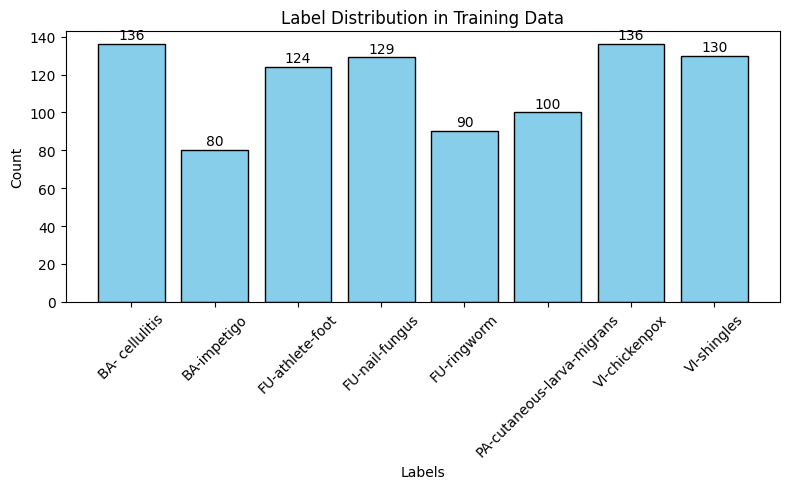

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Count each label
label_counts = df_train["label"].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(label_counts.index, label_counts.values, color='skyblue', edgecolor='black')

# Add count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, int(yval), ha='center', va='bottom')

plt.title("Label Distribution in Training Data")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [35]:
label_counts

label
BA- cellulitis                136
BA-impetigo                    80
FU-athlete-foot               124
FU-nail-fungus                129
FU-ringworm                    90
PA-cutaneous-larva-migrans    100
VI-chickenpox                 136
VI-shingles                   130
Name: count, dtype: int64

In [41]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [88]:
import torch
import timm
import torch.nn as nn
import torch.nn.functional as F

@torch.no_grad()
def load_model(model_path, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = timm.create_model('efficientnet_b0', pretrained=False)
    model.classifier = nn.Linear(model.classifier.in_features, 8)  # 8 classes
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model


@torch.no_grad()
def predict(model, image_tensor, class_names=None, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_tensor = image_tensor.unsqueeze(0).to(device)  # add batch dim

    output = model(image_tensor)
    probabilities = F.softmax(output, dim=1).squeeze()
    predicted_idx = torch.argmax(probabilities).item()

    if class_names:
        return class_names[predicted_idx], probabilities.cpu().numpy()
    return predicted_idx, probabilities.cpu().numpy()


In [89]:
from PIL import Image
import torchvision.transforms as T
import torch
import torch.nn as nn
import kornia.augmentation as K

class ImagePreprocessor:
    def __init__(self, img_size=(224, 224), device=None):
        self.img_size = img_size
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.base_transform = T.Compose([
            T.Resize(self.img_size),
            T.ToTensor()
        ])

        self.kornia_norm = nn.Sequential(
            K.Normalize(
                mean=torch.tensor([0.485, 0.456, 0.406], device=self.device),
                std=torch.tensor([0.229, 0.224, 0.225], device=self.device)
            )
        ).to(self.device)

    def preprocess(self, file) -> torch.Tensor:
        image = Image.open(file).convert("RGB")
        image = self.base_transform(image)
        image = image.to(self.device).unsqueeze(0)
        image = self.kornia_norm(image)
        return image.squeeze(0)  # Return [3, H, W]


In [90]:
from image_preprocessing import ImagePreprocessor

processor = ImagePreprocessor(device=device)
model = load_model("efficientnet_b0_skin_classifier_weights.pth", device=device)

In [91]:
image_tensor = processor.preprocess("skin-disease-datasaet/test_set/VI-chickenpox/14_VI-chickenpox (20).jpg")

In [92]:
image_tensor

tensor([[[ 0.2111,  0.2111,  0.2282,  ...,  0.1426,  0.1254,  0.1083],
         [ 0.2111,  0.2111,  0.2282,  ...,  0.1939,  0.1768,  0.1768],
         [ 0.2111,  0.2111,  0.2282,  ...,  0.2624,  0.2624,  0.2624],
         ...,
         [-0.4397, -0.4226, -0.4054,  ..., -1.1589, -1.5185, -1.5870],
         [-0.4568, -0.4568, -0.4397,  ..., -1.6384, -1.7240, -1.2274],
         [-0.4568, -0.4397, -0.4226,  ..., -1.6042, -1.5528, -0.8678]],

        [[ 0.3978,  0.3978,  0.4153,  ...,  0.3102,  0.2927,  0.2752],
         [ 0.3978,  0.3978,  0.4153,  ...,  0.3627,  0.3452,  0.3452],
         [ 0.3978,  0.3978,  0.4153,  ...,  0.4328,  0.4328,  0.4328],
         ...,
         [-0.3725, -0.3550, -0.3375,  ..., -1.1954, -1.5630, -1.6331],
         [-0.3901, -0.3901, -0.3725,  ..., -1.6856, -1.7731, -1.2829],
         [-0.3901, -0.3725, -0.3550,  ..., -1.6506, -1.6155, -0.9153]],

        [[ 0.4614,  0.4614,  0.4788,  ...,  0.4788,  0.4614,  0.4439],
         [ 0.4614,  0.4614,  0.4788,  ...,  0

In [93]:
label_map = {
    "BA-cellulitis": 0,
    "BA-impetigo": 1,
    "FU-athlete-foot": 2,
    "FU-nail-fungus": 3,
    "FU-ringworm": 4,
    "PA-cutaneous-larva-migrans": 5,
    "VI-chickenpox": 6,
    "VI-shingles": 7
}
idx_to_label = {v: k for k, v in label_map.items()}

In [94]:
idx_to_label

{0: 'BA-cellulitis',
 1: 'BA-impetigo',
 2: 'FU-athlete-foot',
 3: 'FU-nail-fungus',
 4: 'FU-ringworm',
 5: 'PA-cutaneous-larva-migrans',
 6: 'VI-chickenpox',
 7: 'VI-shingles'}

In [95]:

label, probs = predict(model, image_tensor, class_names=idx_to_label, device=device)

In [96]:
print("Predicted label:", label)
print("Probabilities:", probs)

Predicted label: VI-chickenpox
Probabilities: [0.08968432 0.00836672 0.027208   0.04355299 0.02703942 0.10591336
 0.6174882  0.08074704]


In [104]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


In [105]:

# Paths to your data directories
train_dir = 'skin-disease-datasaet/train_set'
val_dir = 'skin-disease-datasaet/test_set'

In [106]:


# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)


In [107]:

# Load images from directories
train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=32, class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=(224,224), batch_size=32, class_mode='categorical'
)


Found 924 images belonging to 8 classes.


Found 233 images belonging to 8 classes.


In [108]:

# Model setup using transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)  # 8 classes

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [109]:


# Train the model
model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 609ms/step - accuracy: 0.5476 - loss: 1.3736 - val_accuracy: 0.8069 - val_loss: 0.5506
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 556ms/step - accuracy: 0.8727 - loss: 0.4024 - val_accuracy: 0.8970 - val_loss: 0.3034
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 570ms/step - accuracy: 0.9373 - loss: 0.1982 - val_accuracy: 0.8798 - val_loss: 0.2703
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 600ms/step - accuracy: 0.9382 - loss: 0.1910 - val_accuracy: 0.9056 - val_loss: 0.2602
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 598ms/step - accuracy: 0.9532 - loss: 0.1432 - val_accuracy: 0.9270 - val_loss: 0.2309
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 599ms/step - accuracy: 0.9669 - loss: 0.1213 - val_accuracy: 0.9227 - val_loss: 0.2102
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 574ms/step - accuracy: 0.9795 - loss: 0.0899 - val_accuracy: 0.9185 - val_loss: 0.2367
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 539ms/step - accuracy: 0.9753 - loss: 0.0903 - val_accu

In [110]:
model.save('skin_disease_model_8_classes.h5')

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from tqdm import tqdm
import timm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Paths to your data directories
train_dir = 'skin-disease-datasaet/train_set'
val_dir = 'skin-disease-datasaet/test_set'

# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets and loaders
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load pretrained EfficientNet
model = timm.create_model('efficientnet_b0', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 8)  # 8 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Validation / Test loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Save the trained model
torch.save(model.state_dict(), 'skin_disease_efficientnet8.pth')

Epoch 1/10: 100%|██████████| 29/29 [00:18<00:00,  1.56it/s]


Epoch [1/10], Loss: 0.6765


Epoch 2/10: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]


Epoch [2/10], Loss: 0.2036


Epoch 3/10: 100%|██████████| 29/29 [00:18<00:00,  1.58it/s]


Epoch [3/10], Loss: 0.1710


Epoch 4/10: 100%|██████████| 29/29 [00:18<00:00,  1.58it/s]


Epoch [4/10], Loss: 0.1500


Epoch 5/10: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]


Epoch [5/10], Loss: 0.0751


Epoch 6/10: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]


Epoch [6/10], Loss: 0.0547


Epoch 7/10: 100%|██████████| 29/29 [00:18<00:00,  1.61it/s]


Epoch [7/10], Loss: 0.0658


Epoch 8/10: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]


Epoch [8/10], Loss: 0.0541


Epoch 9/10: 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]


Epoch [9/10], Loss: 0.0825


Epoch 10/10: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]


Epoch [10/10], Loss: 0.0872
Test Accuracy: 93.16%


In [27]:
import os
BASE_DIR = os.path.abspath(os.path.join(os.path.dirname("skin_disease_prediction.ipynb"), ".."))


In [28]:
import pandas as pd
import csv

# Load user's disease CSV file
csv_path = os.path.join(BASE_DIR, "data", "mayo_diseases.csv")  # User's uploaded CSV file
df = pd.read_csv(csv_path)

In [29]:

# Input and output file paths
input_csv = os.path.join(BASE_DIR, "data", "mayo_diseases.csv")
output_csv = "selected_diseases_symptoms.csv"  # New CSV to create

In [30]:
df.head()

,disease,main_link,Diagnosis_treatment_link,Doctors_departments_link,Overview,Symptoms,When to see a doctor,Causes,Risk factors,Complications,Prevention,Diagnosis,Treatment,Coping and support,Preparing for your appointment,Lifestyle and home remedies
0,Atrial fibrillation,https://www.mayoclinic.org/diseases-conditions...,https://www.mayoclinic.org/diseases-conditions...,https://www.mayoclinic.org/diseases-conditions...,Atrial fibrillation (AFib) is an irregular and...,Symptoms ofAFibmay include:\nFeelings of a fas...,"If you have symptoms of atrial fibrillation, m...",To understand the causes of atrial fibrillatio...,Things that can increase the risk of atrial fi...,Blood clots are a dangerous complication of at...,Healthy lifestyle choices can reduce the risk ...,You may not know you have atrial fibrillation ...,The goals of atrial fibrillation treatment are...,NaN,If you have an irregular or pounding heartbeat...,Following a heart-healthy lifestyle can help p...
1,Hyperhidrosis,https://www.mayoclinic.org/diseases-conditions...,https://www.mayoclinic.org/diseases-conditions...,https://www.mayoclinic.org/diseases-conditions...,Hyperhidrosis (hi-pur-hi-DROE-sis) is excessiv...,The main symptom of hyperhidrosis is heavy swe...,Sometimes excessive sweating is a sign of a se...,Sweating is the body's mechanism to cool itsel...,Risk factors for hyperhidrosis include:\nHavin...,Complications of hyperhidrosis include:\nInfec...,NaN,Diagnosing hyperhidrosis may start with your h...,Treating hyperhidrosis may start with treating...,Hyperhidrosis can be the cause of discomfort a...,You may start by seeing your primary care prov...,The following suggestions may help control swe...
2,Bartholin's cyst,https://www.mayoclinic.org/diseases-conditions...,https://www.mayoclinic.org/diseases-conditions...,https://www.mayoclinic.org/diseases-conditions...,The Bartholin's (BAHR-toe-linz) glands are loc...,"If you have a small, noninfected Bartholin's c...",Call your doctor if you have a painful lump ne...,Experts believe that the cause of a Bartholin'...,NaN,A Bartholin's cyst or abscess may recur and ag...,There's no way to prevent a Bartholin's cyst. ...,"To diagnose a Bartholin's cyst, your doctor ma...",Often a Bartholin's cyst requires no treatment...,NaN,Your first appointment will likely be with eit...,NaN
3,Infant reflux,https://www.mayoclinic.org/diseases-conditions...,https://www.mayoclinic.org/diseases-conditions...,NaN,Infant reflux is when a baby spits up liquid o...,"Most of the time, infant reflux isn't a cause ...",See a healthcare professional if a baby:\nIsn'...,"In infants, the ring of muscle between the eso...",Infant reflux is common. But some things make ...,Infant reflux usually gets better on its own. ...,NaN,"To diagnose infant reflux, a healthcare profes...","For most babies, making some changes to feedin...",NaN,You may start by seeing your baby's primary he...,To minimize reflux:\nFeed your baby in an upri...
4,Hidradenitis suppurativa,https://www.mayoclinic.org/diseases-conditions...,https://www.mayoclinic.org/diseases-conditions...,https://www.mayoclinic.org/diseases-conditions...,Hidradenitis suppurativa (hi-drad-uh-NIE-tis s...,Hidradenitis suppurativa can affect one or sev...,Early diagnosis of hidradenitis suppurativa is...,Hidradenitis suppurativa develops when hair fo...,Factors that increase your chance of developin...,Persistent and severe hidradenitis suppurativa...,NaN,Hidradenitis suppurativa can be mistaken for p...,"Treatment with medicines, surgery or both can ...",Hidradenitis suppurativa can be a challenge to...,You'll likely first see your primary care prov...,Mild hidradenitis suppurativa can sometimes be...


In [31]:
diseases = [
    "Atrial fibrillation",
    "Hyperhidrosis",
    "Hidradenitis suppurativa",
    "Guillain-Barre syndrome",
    "Acute kidney injury",
    "Radiation sickness",
    "ARDS",
    "Autoimmune epilepsy",
    "Frozen shoulder",
    "Dry macular degeneration",
    "Myelofibrosis",
    "Alcoholic hepatitis",
    "Churg-Strauss syndrome",
    "Egg allergy",
    "Peanut allergy",
    "Amyotrophic lateral sclerosis (ALS)",
    "Amyloidosis",
    "Aplastic anemia",
    "Thalassemia",
    "Abdominal aortic aneurysm",
    "Brain aneurysm",
    "Angina",
    "Castleman disease",
    "Anorexia nervosa",
    "Generalized anxiety disorder",
    "Aortic dissection",
    "Color blindness",
    "Severe acute respiratory syndrome (SARS)",
    "Age spots (liver spots)",
    "Complex regional pain syndrome",
    "Interstitial cystitis",
    "Cytomegalovirus (CMV) infection",
    "Delayed sleep phase",
    "Frontotemporal dementia",
    "Dermatographia (Dermatographism)",
    "Dysphagia",
    "Persistent depressive disorder",
    "Pulmonary embolism",
    "Erectile dysfunction",
    "Familial Mediterranean fever",
    "Pulmonary fibrosis",
    "Eye floaters",
    "Functional neurologic disorder/conversion disorder",
    "Gastroparesis",
    "Gender dysphoria",
    "Gaucher disease",
    "Cluster headache",
    "Hemochromatosis",
    "Hiatal hernia",
    "Horner syndrome",
    "HPV infection",
    "Idiopathic intracranial hypertension",
    "Irritable bowel syndrome",
    "Kawasaki disease",
    "Lactose intolerance",
    "Lewy body dementia",
    "Lynch syndrome",
    "Meralgia paresthetica",
    "Morton neuroma",
    "Myasthenia gravis",
    "Narcolepsy",
    "Neuromyelitis optica",
    "Obsessive-compulsive disorder (OCD)",
    "Orthostatic hypotension",
    "Patellar tendinitis",
    "Polycystic ovary syndrome (PCOS)",
    "Postherpetic neuralgia",
    "Primary biliary cholangitis",
    "Raynaud's phenomenon",
    "Restless legs syndrome",
    "Rosacea",
    "Sarcoidosis",
    "Sjogren's syndrome",
    "Small intestinal bacterial overgrowth (SIBO)",
    "Temporomandibular joint (TMJ) disorders",
    "Trigeminal neuralgia",
    "Vasovagal syncope",
    "Waldenstrom macroglobulinemia",
    "Whipple's disease",
    "Wilson's disease",
    "Acoustic neuroma",
    "Burning mouth syndrome",
    "Chronic fatigue syndrome",
    "Dumping syndrome",
    "Ehlers-Danlos syndrome",
    "Fibromyalgia",
    "Gilbert syndrome",
    "Hashimoto's thyroiditis",
    "Interstitial lung disease",
    "Klinefelter syndrome",
    "Mast cell activation syndrome",
    "Nephrotic syndrome",
    "Osgood-Schlatter disease",
    "Paget's disease of bone",
    "Quadriceps tendonitis",
    "Retroperitoneal fibrosis",
    "Stevens-Johnson syndrome",
    "Tourette syndrome",
    "Uveitis",
    "Vitiligo",
    "Wegener's granulomatosis",
    "Xerostomia",
    "Yellow nail syndrome",
    "Zollinger-Ellison syndrome"
]

In [34]:
with open(input_csv, mode='r', encoding='utf-8') as infile, \
     open(output_csv, mode='w', newline='', encoding='utf-8') as outfile:
    
    reader = csv.DictReader(infile)
    writer = csv.DictWriter(outfile, fieldnames=['Disease', 'Symptoms'])
    writer.writeheader()
    
    for row in reader:
        if row['disease'] in diseases:
            writer.writerow({
                'Disease': row['disease'],
                'Symptoms': row['Symptoms']
            })

print(f"Created {output_csv} with {len(diseases)} diseases")

Created selected_diseases_symptoms.csv with 104 diseases


In [1]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
import os

# For Groq
os.environ["OPENAI_API_KEY"] = os.getenv("GROQ_API_KEY") or "your_groq_key"
os.environ["OPENAI_API_BASE"] = "https://api.groq.com/openai/v1"

llm = ChatOpenAI(
    model="llama3-70b-8192",  # or llama3-70b-8192 if supported
    temperature=0.6
)



C:\Users\harme\AppData\Local\Temp\ipykernel_12452\3443397209.py:9: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(


In [2]:
from langchain.prompts import PromptTemplate

prompt_template_name = PromptTemplate(
    input_variables=['symptoms'],
    template= "Convert the following list of medical symptoms into a natural-sounding, continuous one-paragraph query that a patient might say to a doctor. The patient is unaware of any disease name and is just describing what they are experiencing. Use all the symptoms provided, cover everything, and do not break it into points or sentences. Keep the response concise and human-like, as if someone is verbally describing their condition in one paragraph. Do not include any explanation or extra context—just return the patient's paragraph. Symptoms: {symptoms}"
)


In [3]:
chain = prompt_template_name | llm


In [4]:
input_csv = "selected_diseases_symptoms.csv"  # New CSV to create
output_csv = "selected_diseases_symptoms_updated.csv"  # New CSV to create

In [5]:
from tqdm.notebook import tqdm


In [6]:
import csv
from tqdm import tqdm  # or from tqdm.notebook import tqdm for Jupyter

with open(input_csv, mode='r', encoding='utf-8') as infile, \
     open(output_csv, mode='w', newline='', encoding='utf-8') as outfile:

    reader = csv.DictReader(infile)
    writer = csv.DictWriter(outfile, fieldnames=['Disease', 'User_Query'])
    writer.writeheader()

    for row in tqdm(reader, desc="Processing diseases", ascii=True):  # Better tqdm line
        disease = row['Disease']
        symptoms = row['Symptoms']

        try:
            response = chain.invoke({"symptoms": symptoms})
            user_query = response.content if hasattr(response, "content") else str(response)
        except Exception as e:
            user_query = f"Error: {e}"

        writer.writerow({
            'Disease': disease,
            'User_Query': user_query
        })


Processing diseases: 136it [08:01,  3.54s/it]


In [24]:
response = chain.invoke({"symptoms":symptoms})


In [26]:
response.content

'"Doc, I\'ve been having these weird heart flutters and pains in my chest, and lately, I\'ve been feeling really dizzy and tired all the time, even when I\'m just doing simple exercises, and sometimes I get short of breath too."'